In [1]:
import os
import time
import math
import random
import logging
import warnings
import operator
import numpy as np
from copy import copy
from typing import Tuple
from functools import reduce, partial

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.optim.adam import Adam
from torchvision import transforms
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid, save_image

import matplotlib
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
from timm.models.vision_transformer import PatchEmbed, Block

from CNNUtils import train, test, valid, output_metric

%matplotlib inline

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything()

In [3]:
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.,), (1,))])

mnist_train = torchvision.datasets.MNIST('./data/', train=True, transform=trans, download=True)
mnist_train, mnist_val = random_split(mnist_train, [10000, 50000], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=mnist_val, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True)

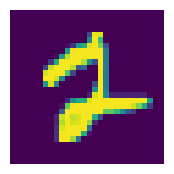

In [4]:
dataiter = iter(train_loader)
sample = next(dataiter)[0][0]
sample = sample.numpy().transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

In [5]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M, )
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2, )  16

    pos = pos.reshape(-1)  # (M, )  64
    out = np.einsum('m, d -> md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)  # (1+H*W, D)
    return pos_embed

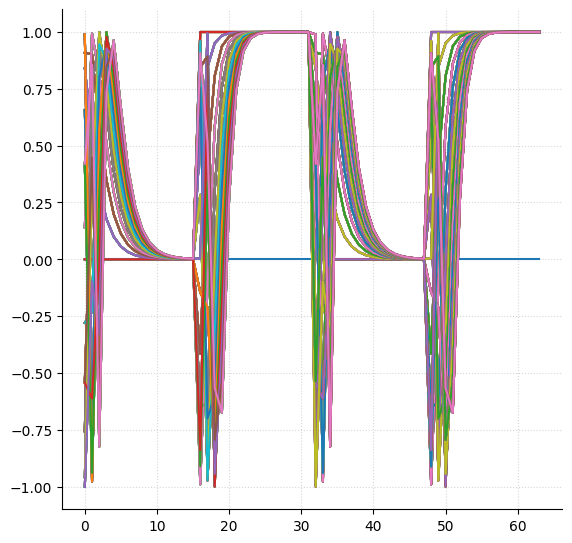

In [6]:
pos_embed = get_2d_sincos_pos_embed(64, 14, cls_token=True)  # (65, 64)

x = np.arange(pos_embed.shape[1])
title_style = dict(family='Times New Roman', size=18, weight='black')
fig = plt.figure(figsize=(5, 5))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
fig.add_axes(ax)
for i in range(pos_embed.shape[0]):
    ax.plot(x, pos_embed[i])
ax.grid(alpha=0.5, linestyle=":")
plt.show()

In [7]:
class MaskedAutoencoderViT(nn.Module):
    """
    Maksed Autoencoder with Vision-Transformer backbone
    """
    def __init__(self, img_size=28, patch_size=2, in_chans=1, embed_dim=128, depth=12, num_heads=8, decoder_embed_dim=32, decoder_depth=8, 
                 decoder_num_heads=8, mlp_ratio=4., norm_layer=nn.LayerNorm):
        super(MaskedAutoencoderViT, self).__init__()
        # --------------------------------------------------------------------------zz
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches  # 64

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # (1, 1, 64)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)   # fixed sin-cos embedding (1, 65, 64)

        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer) 
                                     for _ in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, 
                                                   norm_layer=norm_layer) for _ in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Sequential(nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True), nn.Sigmoid())  # decoder to patch
        # --------------------------------------------------------------------------
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)  # (65, 64)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))  # (1, 65, 64)

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))  # (1, 65, 32)
        
        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))  # (embed_dim, in_chans, patch_size, patch_size)  (64, 3, 4, 4)
        
        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-samle shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))  # 64 * 0.25 = 16 只保留16个patch

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]  (N, L)
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # 从小到大排序，返回索引 (N, L)
        ids_restore = torch.argsort(ids_shuffle, dim=1)  # 返回ids_shuffle中，原序列0,1,2,...的索引

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))  # (N, 16, D) 只保留16个patch的编码  !!!这里打乱了patch的 顺序
        
        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)  # 原始序列编码所对应的掩模  (N, L)
        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)  # (B, 64, 64)
        
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]  # (B, 64, 64)

        # masking: length -> length * mask_ratio
        # x: (N, 16, D), maks: (N, L), ids_restore: (N, L) 
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]  # (1, 1, 64)
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)  # (B, 1, 64)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 16+1, 64)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)  # (B, 16+1, 64)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)  # (N, 17, 32)
        
        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)  # (N, 65-17(64-16=48), 32)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token (N, L, 32)
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token (N, L+1, 32)
        
        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)  # (N, L+1, 4*4*3)

        # remove cls token
        x = x[:, 1:, :]

        return x  # (N, L, 4*4*3)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2*3)
        """
        p = self.patch_embed.patch_size[0]  # 4
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p  # 8
        x = imgs.reshape(shape=(imgs.shape[0], 1, h, p, w, p))
        x = torch.einsum('nchpwq -> nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 1))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
        x = torch.einsum('nhwpqc -> nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 1, h * p, h * p))
        return imgs

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove
        """
        target = self.patchify(imgs)  # (N, L, patch_size**2*3)
        loss = (pred - target) ** 2
        #loss = loss.mean()
        loss = loss.mean(dim=-1)  # (N, L), mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss
    
    def forward(self, imgs, mask_ratio=0.75):
        # latent: (N, 16, D), maks: (N, L), ids_restore: (N, L) 
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        # pred: (N, L, 4*4*3)
        pred = self.forward_decoder(latent, ids_restore)  # (N, L, p**2*3) 我们发现在decoder里面已经进行了unshuffle操作，所以这里的pred就是rencons
        recons = self.unpatchify(pred)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, recons, mask

In [8]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [9]:
def pretrain(model, train_loader, device):
    model.train()

    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    train_len = len(train_loader)
    path = './model/mae.pt'
    for epoch in range(200):
        objs = AverageMeter()
        for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
            image = image.to(device)
            optimizer.zero_grad()
            
            loss, recons, mask = model(image)
            
            loss.backward()
            optimizer.step()

            n = image.shape[0]
            objs.update(loss.data, n)  # 计算所有训练样本的平均损失
            if (batch_idx + 1) == len(train_loader):
                print('epoch: {}, loss: {:.4f}'.format(epoch+1, objs.avg))

        scheduler.step()
    
    torch.save(model.state_dict(), path)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mae = MaskedAutoencoderViT()
mae = mae.to(device)

In [11]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)

In [12]:
model_summary(mae)

cls_token: 1x1x128 = 128
mask_token: 1x1x32 = 32
patch_embed.proj.weight: 128x1x2x2 = 512
patch_embed.proj.bias: 128
blocks.0.norm1.weight: 128
blocks.0.norm1.bias: 128
blocks.0.attn.qkv.weight: 384x128 = 49152
blocks.0.attn.qkv.bias: 384
blocks.0.attn.proj.weight: 128x128 = 16384
blocks.0.attn.proj.bias: 128
blocks.0.norm2.weight: 128
blocks.0.norm2.bias: 128
blocks.0.mlp.fc1.weight: 512x128 = 65536
blocks.0.mlp.fc1.bias: 512
blocks.0.mlp.fc2.weight: 128x512 = 65536
blocks.0.mlp.fc2.bias: 128
blocks.1.norm1.weight: 128
blocks.1.norm1.bias: 128
blocks.1.attn.qkv.weight: 384x128 = 49152
blocks.1.attn.qkv.bias: 384
blocks.1.attn.proj.weight: 128x128 = 16384
blocks.1.attn.proj.bias: 128
blocks.1.norm2.weight: 128
blocks.1.norm2.bias: 128
blocks.1.mlp.fc1.weight: 512x128 = 65536
blocks.1.mlp.fc1.bias: 512
blocks.1.mlp.fc2.weight: 128x512 = 65536
blocks.1.mlp.fc2.bias: 128
blocks.2.norm1.weight: 128
blocks.2.norm1.bias: 128
blocks.2.attn.qkv.weight: 384x128 = 49152
blocks.2.attn.qkv.bias: 3

In [13]:
path = './model/mae.pt'

mae.load_state_dict(torch.load(path))
mae.eval()
print('done')

done


In [14]:
dataiter = iter(test_loader)
x_test, y_test = next(dataiter)  # 64, 3, 32, 32

x_test_original = x_test[:20]
x_test = x_test_original.numpy().transpose(0, 2, 3, 1)
y_test = y_test[:20].numpy()

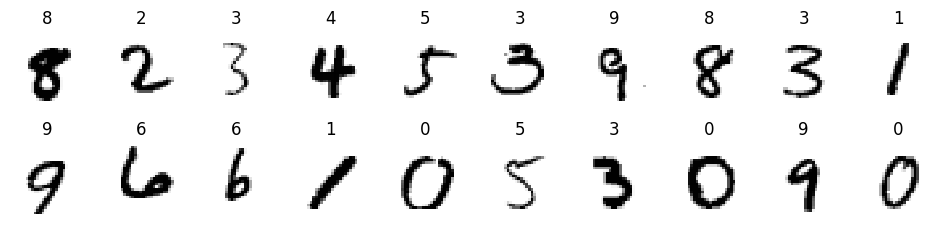

In [15]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

n_rows = 2
n_cols = 10
fig = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_test[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig('./mae_originals.pdf', bbox_inches='tight', dpi=300)

In [16]:
return_tuple = mae(x_test_original.cuda())
recons = return_tuple[1]
recons = recons.detach().cpu().numpy()
recons = recons.transpose(0, 2, 3, 1)

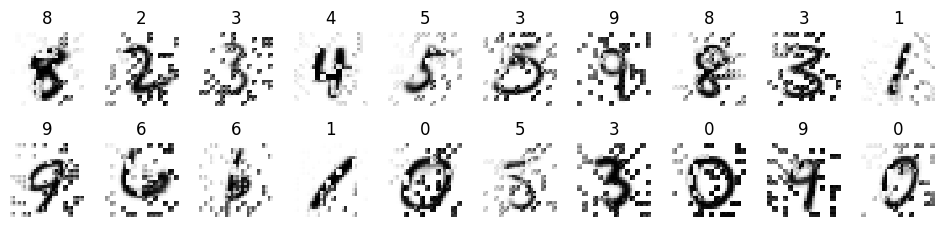

In [17]:
n_rows = 2
n_cols = 10
fig = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(recons[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig('./mae_reconstructions.pdf', bbox_inches='tight', dpi=300)

In [18]:
class Encoder(MaskedAutoencoderViT):
    def forward_encoder(self, x):
        # embed patches
        x = self.patch_embed(x)  # (B, 64, 64)
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]  # (B, 64, 64)
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]  # (1, 1, 64)
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)  # (B, 1, 64)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 64+1, 64)
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)  # (B, 64+1, 64)
        latent = x[:, 0, :]
        return latent
         
    def forward(self, imgs):
        latent = self.forward_encoder(imgs)
        return latent

In [19]:
encoder = Encoder().cuda()

path = './model/mae.pt'
encoder.load_state_dict(torch.load(path))
encoder.eval()
print('done')

done


In [20]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_mae.pdf', dpi=300, bbox_inches='tight')

In [21]:
train_codings = []
train_tar = []
for batch_idx, (image, label) in enumerate(train_loader):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        codings = encoder(image)
    train_codings.append(codings.cpu().data)
    train_tar.append(label.cpu().data)

x_train = torch.concat(train_codings)
y_train = torch.concat(train_tar)

x_train_numpy = x_train.numpy()
y_train_numpy = y_train.numpy()

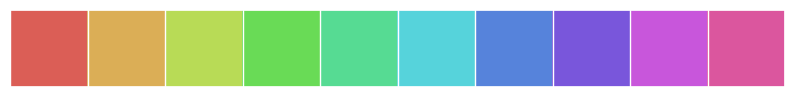

In [22]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

palette = sns.color_palette("hls", 10)
sns.palplot(palette)

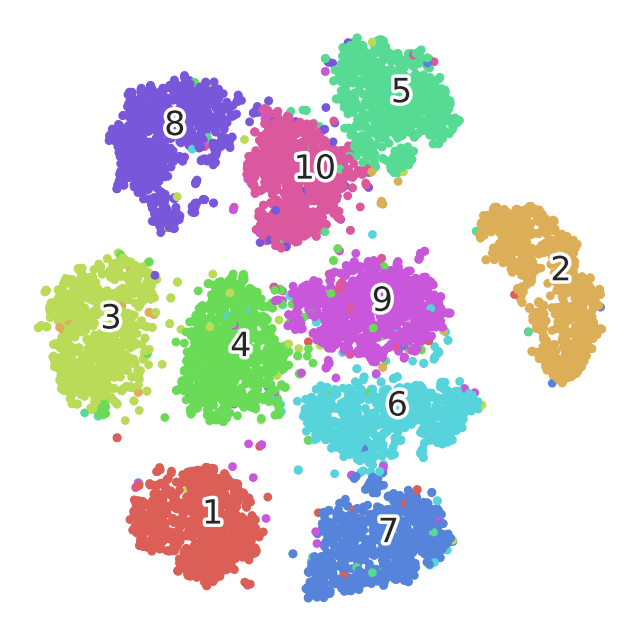

In [23]:
tsne_proj = TSNE(random_state=42).fit_transform(x_train_numpy)

scatter(tsne_proj, y_train_numpy)

## Metrics

In [24]:
def mean_distance(codings, label, c=10):
    codings_per_class = []  # [(16, ) * 10]
    for i in range(c):
        codings_per_class.append(codings[label == i, :])
    centers = [torch.mean(codings_per_class[i], 0) for i in range(c)]
    
    inter_class_distance = torch.tensor(0.)
    for k in range(c - 1):
        for t in range(k + 1, c):
            inter_class_distance += torch.dist(centers[k], centers[t], p=2)
    mean_inter_class_distance = inter_class_distance / (c * (c - 1) / 2)
    
    intra_class_distance = torch.tensor(0.)
    for i in range(c):
        per_intra_class_distance = torch.tensor(0.)
        per_class_features = codings_per_class[i]
        center_feature = centers[i]
        num = per_class_features.size(0)
        for j in range(num):
            per_intra_class_distance += torch.dist(per_class_features[j], center_feature, p=2)
        per_intra_class_distance = per_intra_class_distance / num
        
        intra_class_distance += per_intra_class_distance
    mean_intra_class_distance = intra_class_distance / c
    return mean_intra_class_distance, mean_inter_class_distance

In [25]:
mean_intra_class_distance, mean_inter_class_distance = mean_distance(x_train, y_train)

mean_intra_class_distance, mean_inter_class_distance

(tensor(3.5275), tensor(4.5076))

## Fine-tuning

In [26]:
encoder = Encoder()

path = './model/mae.pt'
encoder.load_state_dict(torch.load(path))

<All keys matched successfully>

In [27]:
for param in encoder.parameters():
    param.requires_grad = False

for param in encoder.blocks[-1].parameters():
    param.requires_grad = True

In [28]:
cls_head = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64, 10))

In [29]:
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.,), (1,))])

mnist_train = torchvision.datasets.MNIST('./data/', train=True, transform=trans, download=True)
mnist_train, mnist_val = random_split(mnist_train, [100, 59900], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=mnist_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True)

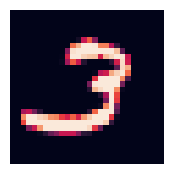

In [30]:
dataiter = iter(train_loader)
sample = next(dataiter)[0][0]
sample = sample.numpy().transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

In [31]:
classifier = nn.Sequential(encoder, cls_head)
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [32]:
model_summary(classifier)

0.blocks.11.norm1.weight: 128
0.blocks.11.norm1.bias: 128
0.blocks.11.attn.qkv.weight: 384x128 = 49152
0.blocks.11.attn.qkv.bias: 384
0.blocks.11.attn.proj.weight: 128x128 = 16384
0.blocks.11.attn.proj.bias: 128
0.blocks.11.norm2.weight: 128
0.blocks.11.norm2.bias: 128
0.blocks.11.mlp.fc1.weight: 512x128 = 65536
0.blocks.11.mlp.fc1.bias: 512
0.blocks.11.mlp.fc2.weight: 128x512 = 65536
0.blocks.11.mlp.fc2.bias: 128
1.0.weight: 64x128 = 8192
1.0.bias: 64
1.3.weight: 10x64 = 640
1.3.bias: 10

Total Trainable Parameters: 207178


In [33]:
for _, (data, label) in enumerate(train_loader):
    print(label)

tensor([9, 4, 8, 9, 5, 1, 1, 3, 7, 9, 1, 7, 9, 3, 5, 6, 4, 7, 1, 6, 6, 3, 1, 7,
        6, 1, 9, 4, 2, 4, 2, 7])
tensor([1, 0, 7, 9, 7, 1, 6, 8, 3, 6, 6, 1, 4, 2, 9, 2, 6, 5, 7, 1, 0, 2, 3, 3,
        9, 2, 3, 9, 6, 6, 2, 1])
tensor([3, 0, 0, 6, 5, 2, 5, 6, 4, 8, 5, 9, 0, 9, 8, 7, 0, 6, 5, 3, 1, 7, 6, 2,
        0, 7, 8, 5, 4, 2, 2, 9])
tensor([3, 1, 2, 3])


In [34]:
tic = time.time()
early_epoch = 0
acc_list = [0.00]
path = './model/finetune_mae.pt'

for epoch in range(100):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(classifier, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(classifier, test_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to finetune_mae.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(classifier.state_dict(), path)
        early_epoch = 0
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]
        early_epoch += 1
        if early_epoch == 15:
            print('Early stopping, the most optimal valid_acc is: {:.2f}%'.format(acc_list[-1].item()))
            break
  
toc = time.time()
print("Training Time: {:.2f} seconds".format(toc-tic))
print("**************************************************")

Epoch: 001 - train_loss: 2.3006 - train_acc: 10.0000 - valid_loss: 2.2235 - valid_acc: 26.2700
val_acc improved from 0.0000 to 26.2700, saving model to finetune_mae.pt
Epoch: 002 - train_loss: 2.1584 - train_acc: 37.0000 - valid_loss: 2.1549 - valid_acc: 47.1500
val_acc improved from 26.2700 to 47.1500, saving model to finetune_mae.pt
Epoch: 003 - train_loss: 2.0343 - train_acc: 53.0000 - valid_loss: 2.0803 - valid_acc: 48.8000
val_acc improved from 47.1500 to 48.8000, saving model to finetune_mae.pt
Epoch: 004 - train_loss: 1.9209 - train_acc: 56.0000 - valid_loss: 1.9915 - valid_acc: 48.3100
val_acc did not improve from 48.8000
Epoch: 005 - train_loss: 1.8111 - train_acc: 55.0000 - valid_loss: 1.8902 - valid_acc: 48.9400
val_acc improved from 48.8000 to 48.9400, saving model to finetune_mae.pt
Epoch: 006 - train_loss: 1.6706 - train_acc: 60.0000 - valid_loss: 1.7673 - valid_acc: 53.0600
val_acc improved from 48.9400 to 53.0600, saving model to finetune_mae.pt
Epoch: 007 - train_loss:

In [35]:
path = './model/finetune_mae.pt'

classifier.load_state_dict(torch.load(path))
classifier.eval()
print('done')

done


In [36]:
tar_test, pre_test = test(classifier, valid_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [37]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 92.82, AA: 92.73, Kappa: 0.9202
*******************************************************************
Recal: [97.11 97.18 92.84 94.54 89.96 92.41 96.38 92.58 80.59 93.77]
*******************************************************************
